<a id="top"></a>

# Hotel Bookings (Classification)

# Outline

- [Read Data](#read_data)
- [Create target and features](#create_y_and_X)
- [Split data into train and test](#train_test_split)
- [View descriptive statistics](#descriptive_statistics)
- [View target and feature distributions](#distributions)
- [View correlations](#correlations)
- [View relationships between target and features](#pair_plots)
- [Standardize predictors](#standardize_predictors)
- [Predictive models](#predictive_models)
- [Logistic regression](#logistic_regression)
- [K-nearest neighbors](#k_nearest_neighbors)
- [Linear discriminant analysis](#linear_discriminant_analysis)
- [Support vector machines](#support_vector_machines)
- [Extremely Randomized Trees](#extra_trees)
- [Compare models](#compare_models)

# Import packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from time import time
from pprint import pprint

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, cohen_kappa_score, precision_recall_fscore_support

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

<a id="read_data"></a>

# Read data

In [2]:
bookings_filepath = 'https://github.com/cbrownley/2022MLWEEK_MLWITHPYTHON/blob/main/data/hotel_bookings.csv.gz?raw=true'

df_raw = pd.read_csv(bookings_filepath, compression='gzip')

In [3]:
df_raw.head()

,is_requested,effective_daily_price,cleaning_fee,checkouts,reviews,days_since_last_booking,image_quality_score,total_overall_rating,professional_pictures,checkin_gap,...,person_capacity_3,person_capacity_4,person_capacity_5,person_capacity_6,person_capacity_7,person_capacity_8,person_capacity_9,cancel_policy_3,cancel_policy_4,cancel_policy_5
0,True,145.849886,22.450342,0.0,0.0,62.76247,0.925428,0.0,0.0,7.0,...,0,0,0,1,0,0,0,1,0,0
1,False,108.297186,0.000000,0.0,0.0,62.76247,0.774094,0.0,0.0,7.0,...,0,0,0,0,0,0,0,1,0,0
2,False,70.860004,0.000000,0.0,0.0,62.76247,0.082612,0.0,0.0,7.0,...,0,0,0,0,0,0,0,0,1,0
3,True,44.800000,0.000000,8.0,7.0,181.00000,0.447015,30.0,0.0,7.0,...,0,0,0,0,0,0,0,0,1,0
4,True,48.479527,28.286623,32.0,22.0,39.00000,0.531061,105.0,18.0,7.0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_raw.shape

(94595, 400)

In [5]:
list(df_raw.columns)

['is_requested',
 'effective_daily_price',
 'cleaning_fee',
 'checkouts',
 'reviews',
 'days_since_last_booking',
 'image_quality_score',
 'total_overall_rating',
 'professional_pictures',
 'checkin_gap',
 'checkout_gap',
 'occ_plus_minus_7_ds_night',
 'occ_plus_minus_14_ds_night',
 'occupancy_trailing_90_ds',
 'min_nights',
 'max_nights',
 'price_booked_most_recent',
 'listing_views_2_6_ds_night',
 'unique_searchers_0_6_ds_night',
 'contacts_0_6_ds_night',
 'reserve_requests_0_6_ds_night',
 'is_booked_0_6_ds_night',
 'avail_listings_ds_night',
 'kdt_score',
 'r_kdt_views_0_6_avg_n100',
 'r_kdt_n_active_n100',
 'r_kdt_n_available_n100',
 'r_kdt_price_n100_p50',
 'r_kdt_price_available_n100_p50',
 'r_kdt_price_booked_n100_p50',
 'is_instant_bookable',
 'has_wireless_internet',
 'ds_night_is_weekend',
 'day_of_week_1',
 'day_of_week_2',
 'day_of_week_3',
 'day_of_week_4',
 'day_of_week_5',
 'day_of_week_6',
 'day_of_year_2',
 'day_of_year_3',
 'day_of_year_4',
 'day_of_year_5',
 'day_of_

<a id="create_y_and_X"></a>

# Create target, y, and predictor, X, variables

In [6]:
# Create random sample of data with 5% of observations to use to explore and model data
df = df_raw.sample(frac=.05, replace=False, random_state=6)
df.shape

(4730, 400)

In [7]:
# requested_mapping = {True: 1, False: 0}
# df['dim_is_requested'] = df['dim_is_requested'].map(requested_mapping)

In [8]:
boolean_columns = [col for col in df.iloc[:, 1:] 
                   if np.isin(df[col].dropna().unique(), [0, 1]).all()]

numeric_columns = df.iloc[:, 1:].columns.difference(boolean_columns).tolist()

print('All cols: {} Boolean cols: {} Numeric cols: {}'.format(df.shape[1], 
                                                              len(boolean_columns), 
                                                              len(numeric_columns)))

All cols: 400 Boolean cols: 370 Numeric cols: 29


In [9]:
X_bool = df[boolean_columns].values.astype(float)
X_bool

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [10]:
list(df[boolean_columns].columns), len(df[boolean_columns].columns)

(['is_instant_bookable',
  'has_wireless_internet',
  'ds_night_is_weekend',
  'day_of_week_1',
  'day_of_week_2',
  'day_of_week_3',
  'day_of_week_4',
  'day_of_week_5',
  'day_of_week_6',
  'day_of_year_2',
  'day_of_year_3',
  'day_of_year_4',
  'day_of_year_5',
  'day_of_year_6',
  'day_of_year_7',
  'day_of_year_8',
  'day_of_year_9',
  'day_of_year_10',
  'day_of_year_11',
  'day_of_year_12',
  'day_of_year_13',
  'day_of_year_14',
  'day_of_year_15',
  'day_of_year_16',
  'day_of_year_17',
  'day_of_year_18',
  'day_of_year_19',
  'day_of_year_20',
  'day_of_year_21',
  'day_of_year_22',
  'day_of_year_23',
  'day_of_year_24',
  'day_of_year_25',
  'day_of_year_26',
  'day_of_year_27',
  'day_of_year_28',
  'day_of_year_29',
  'day_of_year_30',
  'day_of_year_31',
  'day_of_year_32',
  'day_of_year_33',
  'day_of_year_34',
  'day_of_year_35',
  'day_of_year_36',
  'day_of_year_37',
  'day_of_year_38',
  'day_of_year_39',
  'day_of_year_40',
  'day_of_year_41',
  'day_of_year_42

In [11]:
X_num = df[numeric_columns].values.astype(float)
X_num

array([[9.47500000e+03, 7.00000000e+00, 7.00000000e+00, ...,
        6.00000000e+00, 2.30000000e+01, 7.85285714e+02],
       [2.79780000e+04, 7.00000000e+00, 7.00000000e+00, ...,
        5.00000000e+00, 1.90000000e+01, 1.80814286e+03],
       [2.15810000e+04, 7.00000000e+00, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.47585714e+03],
       ...,
       [2.66120000e+04, 0.00000000e+00, 1.00000000e+00, ...,
        5.00000000e+00, 1.80000000e+01, 2.10642857e+03],
       [3.31800000e+03, 7.00000000e+00, 7.00000000e+00, ...,
        8.00000000e+00, 3.90000000e+01, 6.29285714e+02],
       [1.14780000e+04, 7.00000000e+00, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.55100000e+03]])

In [12]:
list(df[numeric_columns].columns), len(df[numeric_columns].columns)

(['avail_listings_ds_night',
  'checkin_gap',
  'checkout_gap',
  'checkouts',
  'cleaning_fee',
  'contacts_0_6_ds_night',
  'days_since_last_booking',
  'effective_daily_price',
  'image_quality_score',
  'is_booked_0_6_ds_night',
  'kdt_score',
  'listing_views_2_6_ds_night',
  'max_nights',
  'min_nights',
  'occ_plus_minus_14_ds_night',
  'occ_plus_minus_7_ds_night',
  'occupancy_trailing_90_ds',
  'price_booked_most_recent',
  'professional_pictures',
  'r_kdt_n_active_n100',
  'r_kdt_n_available_n100',
  'r_kdt_price_available_n100_p50',
  'r_kdt_price_booked_n100_p50',
  'r_kdt_price_n100_p50',
  'r_kdt_views_0_6_avg_n100',
  'reserve_requests_0_6_ds_night',
  'reviews',
  'total_overall_rating',
  'unique_searchers_0_6_ds_night'],
 29)

In [13]:
X = df.iloc[:, 1:].values
X

array([[84.0, 25.0, 8.0, ..., 0, 0, 1],
       [67.86233846681709, 21.38111686706543, 5.0, ..., 0, 0, 1],
       [91.02908076366704, 0.0, 1.0, ..., 1, 0, 0],
       ...,
       [78.80350047998027, 0.0, 9.0, ..., 0, 0, 1],
       [32.72857142857143, 30.0, 17.0, ..., 0, 1, 0],
       [130.0, 0.0, 0.0, ..., 1, 0, 0]], dtype=object)

In [14]:
list(df.iloc[:, 1:].columns), len(df.iloc[:, 1:].columns)

(['effective_daily_price',
  'cleaning_fee',
  'checkouts',
  'reviews',
  'days_since_last_booking',
  'image_quality_score',
  'total_overall_rating',
  'professional_pictures',
  'checkin_gap',
  'checkout_gap',
  'occ_plus_minus_7_ds_night',
  'occ_plus_minus_14_ds_night',
  'occupancy_trailing_90_ds',
  'min_nights',
  'max_nights',
  'price_booked_most_recent',
  'listing_views_2_6_ds_night',
  'unique_searchers_0_6_ds_night',
  'contacts_0_6_ds_night',
  'reserve_requests_0_6_ds_night',
  'is_booked_0_6_ds_night',
  'avail_listings_ds_night',
  'kdt_score',
  'r_kdt_views_0_6_avg_n100',
  'r_kdt_n_active_n100',
  'r_kdt_n_available_n100',
  'r_kdt_price_n100_p50',
  'r_kdt_price_available_n100_p50',
  'r_kdt_price_booked_n100_p50',
  'is_instant_bookable',
  'has_wireless_internet',
  'ds_night_is_weekend',
  'day_of_week_1',
  'day_of_week_2',
  'day_of_week_3',
  'day_of_week_4',
  'day_of_week_5',
  'day_of_week_6',
  'day_of_year_2',
  'day_of_year_3',
  'day_of_year_4',
  '

In [15]:
X_combined = pd.concat([pd.DataFrame(X_num,  columns=list(df[numeric_columns].columns)), 
                        pd.DataFrame(X_bool, columns=list(df[boolean_columns].columns))], axis=1)
X_combined.shape

(4730, 399)

In [16]:
X_combined.columns

Index(['avail_listings_ds_night', 'checkin_gap', 'checkout_gap', 'checkouts',
       'cleaning_fee', 'contacts_0_6_ds_night', 'days_since_last_booking',
       'effective_daily_price', 'image_quality_score',
       'is_booked_0_6_ds_night',
       ...
       'person_capacity_3', 'person_capacity_4', 'person_capacity_5',
       'person_capacity_6', 'person_capacity_7', 'person_capacity_8',
       'person_capacity_9', 'cancel_policy_3', 'cancel_policy_4',
       'cancel_policy_5'],
      dtype='object', length=399)

In [17]:
y = np.where(df['is_requested'].values == True, 1, 0)

print('Class labels:', np.unique(y), np.unique(y), 
      [(i, val) for (i, val) in enumerate(np.bincount(y))])

Class labels: [0 1] [0 1] [(0, 3368), (1, 1362)]


<a id="train_test_split"></a>

# [Split data into train and test sets](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined.values, y, test_size=0.3, random_state=1, stratify=y)

In [19]:
print('Labels counts in y:',       np.bincount(y),       
      [round(float(cnt) / np.sum(np.bincount(y)) * 100, 1) for cnt in np.bincount(y)])

print('Labels counts in y_train:', np.bincount(y_train), 
      [round(cnt / np.sum(np.bincount(y_train)) * 100, 1) for cnt in np.bincount(y_train)])

print('Labels counts in y_test: ',  np.bincount(y_test),  
      [round(cnt / np.sum(np.bincount(y_test)) * 100, 1) for cnt in np.bincount(y_test)])

Labels counts in y: [3368 1362] [71.2, 28.8]
Labels counts in y_train: [2358  953] [71.2, 28.8]
Labels counts in y_test:  [1010  409] [71.2, 28.8]


<a id="descriptive_statistics"></a>

# View descriptive statistics

In [20]:
pd.set_option('display.max_rows', None)

In [21]:
data = pd.DataFrame(np.hstack((y_train.reshape(-1,1).astype(float), X_train.astype(float))), 
                    columns=['is_requested'] + list(X_combined.columns))

data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
is_requested,3311.0,0.29,0.45,0.00,0.00,0.00,1.00,1.00
avail_listings_ds_night,3311.0,19704.98,8811.35,1064.00,10769.00,21770.00,25517.00,37892.00
checkin_gap,3311.0,6.28,1.75,0.00,7.00,7.00,7.00,7.00
checkout_gap,3311.0,6.47,1.57,0.00,7.00,7.00,7.00,7.00
checkouts,3311.0,10.53,14.85,0.00,0.00,4.00,15.00,100.00
cleaning_fee,3311.0,28.24,32.08,0.00,0.00,22.35,44.20,150.00
contacts_0_6_ds_night,3311.0,523.90,238.89,52.00,384.57,505.29,627.57,1261.00
days_since_last_booking,3311.0,63.32,76.65,0.00,11.00,53.00,62.76,438.00
effective_daily_price,3311.0,113.23,70.84,0.05,70.00,95.00,132.37,699.00
image_quality_score,3311.0,0.55,0.30,0.00,0.31,0.54,0.82,1.00


In [22]:
pd.reset_option('display.max_rows')

## Check for missing values

In [23]:
# Sort variables by number of missing values, descending
data.isna().sum().sort_values(ascending=False)

is_requested       0
day_of_year_243    0
day_of_year_253    0
day_of_year_252    0
day_of_year_251    0
                  ..
day_of_year_93     0
day_of_year_92     0
day_of_year_91     0
day_of_year_90     0
cancel_policy_5    0
Length: 400, dtype: int64

<a id="distributions"></a>

# View target distribution

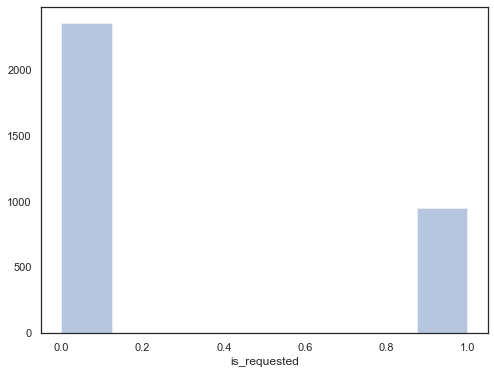

In [24]:
plt.subplots(figsize=(8,6))
sns.distplot(data.is_requested, kde=False);

# View predictor distributions by target category

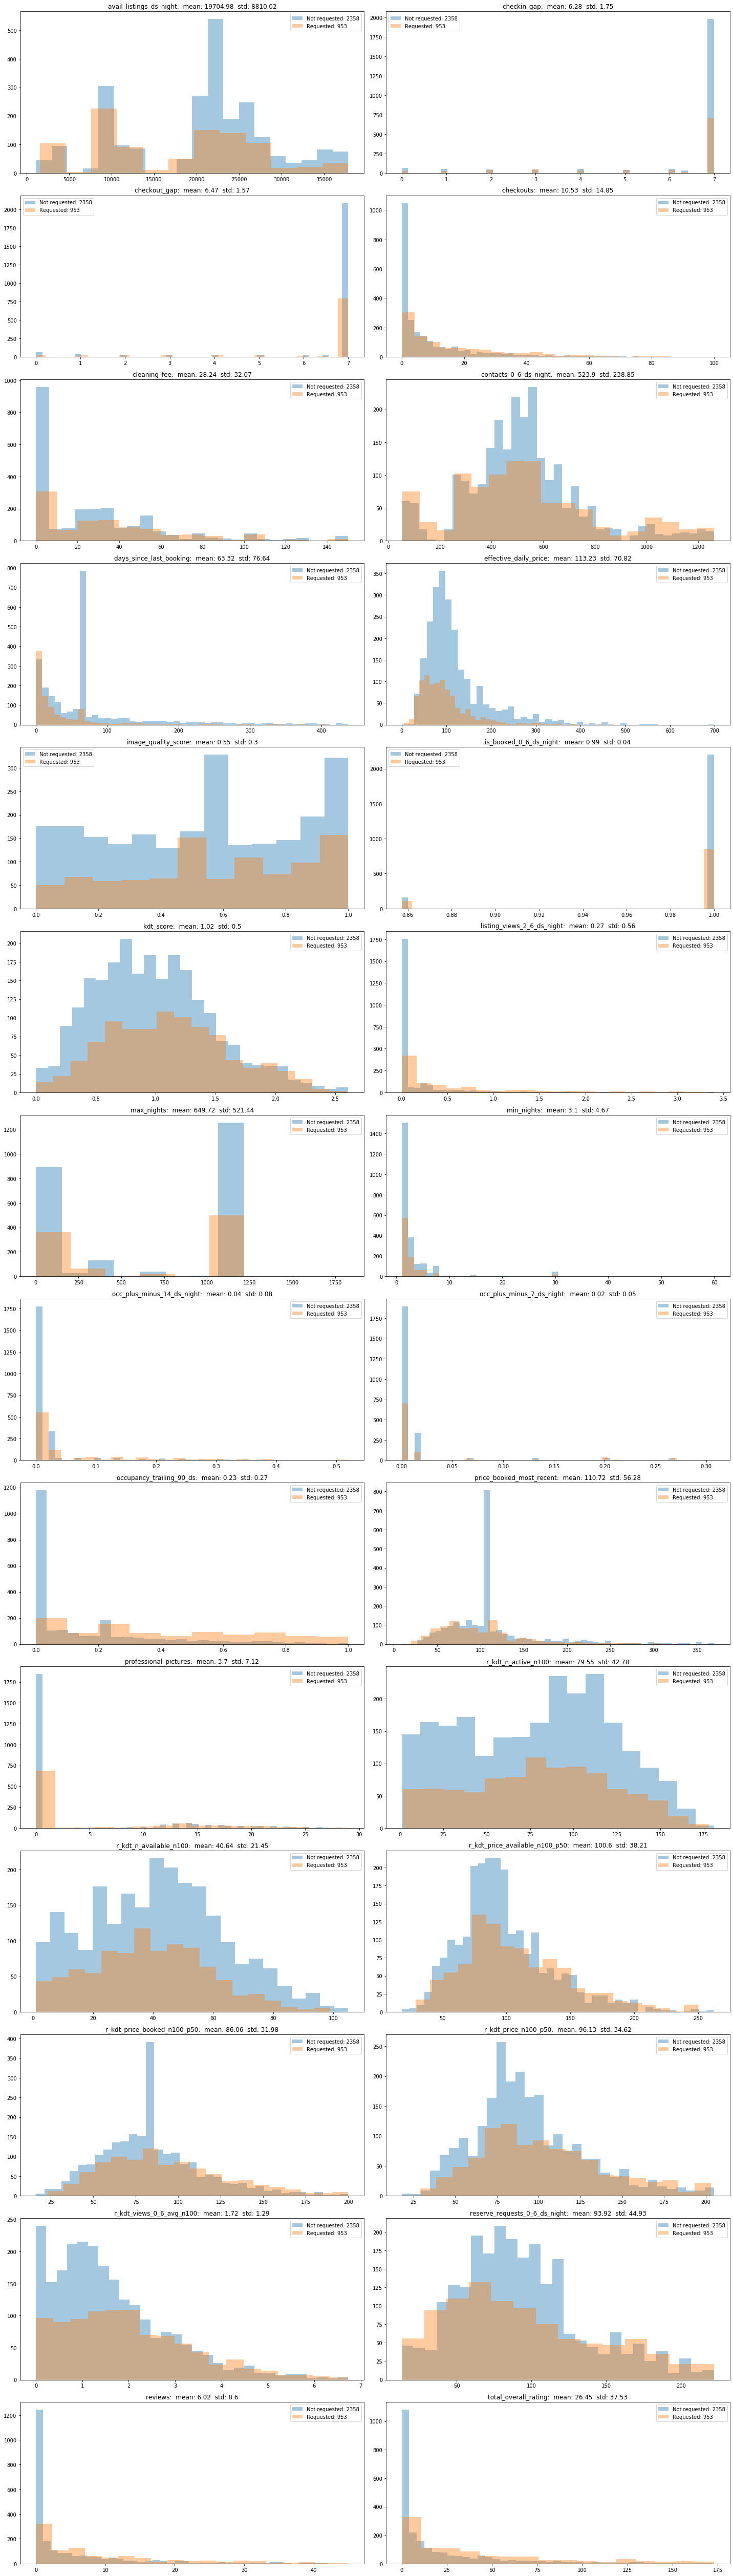

In [315]:
f, axs = plt.subplots(14, 2, figsize=(20,70))

for i, feat in enumerate(data.iloc[:,1:29].values.T):
    sns.distplot(feat[y_train==0], ax=axs.flat[i], kde=False, label='{}: {}'.format('Not requested', len(y_train[y_train==0])))
    sns.distplot(feat[y_train==1], ax=axs.flat[i], kde=False, label='{}: {}'.format('Requested',     len(y_train[y_train==1])))
    axs.flat[i].set_title('{}:  mean: {}  std: {}'.format(list(data.iloc[:,1:29].columns)[i], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()
plt.tight_layout();

<a id="correlations"></a>

# View predictor  [correlations](https://en.wikipedia.org/wiki/Correlation_and_dependence)

In [316]:
dat = data.iloc[:,:29]
dat.describe().round(2).T.sort_values(by=['mean'], ascending=False)

,count,mean,std,min,25%,50%,75%,max
avail_listings_ds_night,3311.0,19704.98,8811.35,1064.00,10769.00,21770.00,25517.00,37892.00
max_nights,3311.0,649.72,521.52,1.00,30.00,1125.00,1125.00,1825.00
contacts_0_6_ds_night,3311.0,523.90,238.89,52.00,384.57,505.29,627.57,1261.00
effective_daily_price,3311.0,113.23,70.84,0.05,70.00,95.00,132.37,699.00
price_booked_most_recent,3311.0,110.72,56.28,9.00,75.00,109.75,118.00,370.00
r_kdt_price_available_n100_p50,3311.0,100.60,38.22,18.00,75.82,92.60,120.66,262.50
r_kdt_price_n100_p50,3311.0,96.13,34.63,18.00,73.52,89.76,115.00,205.00
reserve_requests_0_6_ds_night,3311.0,93.92,44.94,13.14,61.57,86.57,117.43,222.14
r_kdt_price_booked_n100_p50,3311.0,86.06,31.98,16.16,64.73,85.00,102.45,200.00
r_kdt_n_active_n100,3311.0,79.55,42.79,1.00,42.00,84.00,112.00,181.00


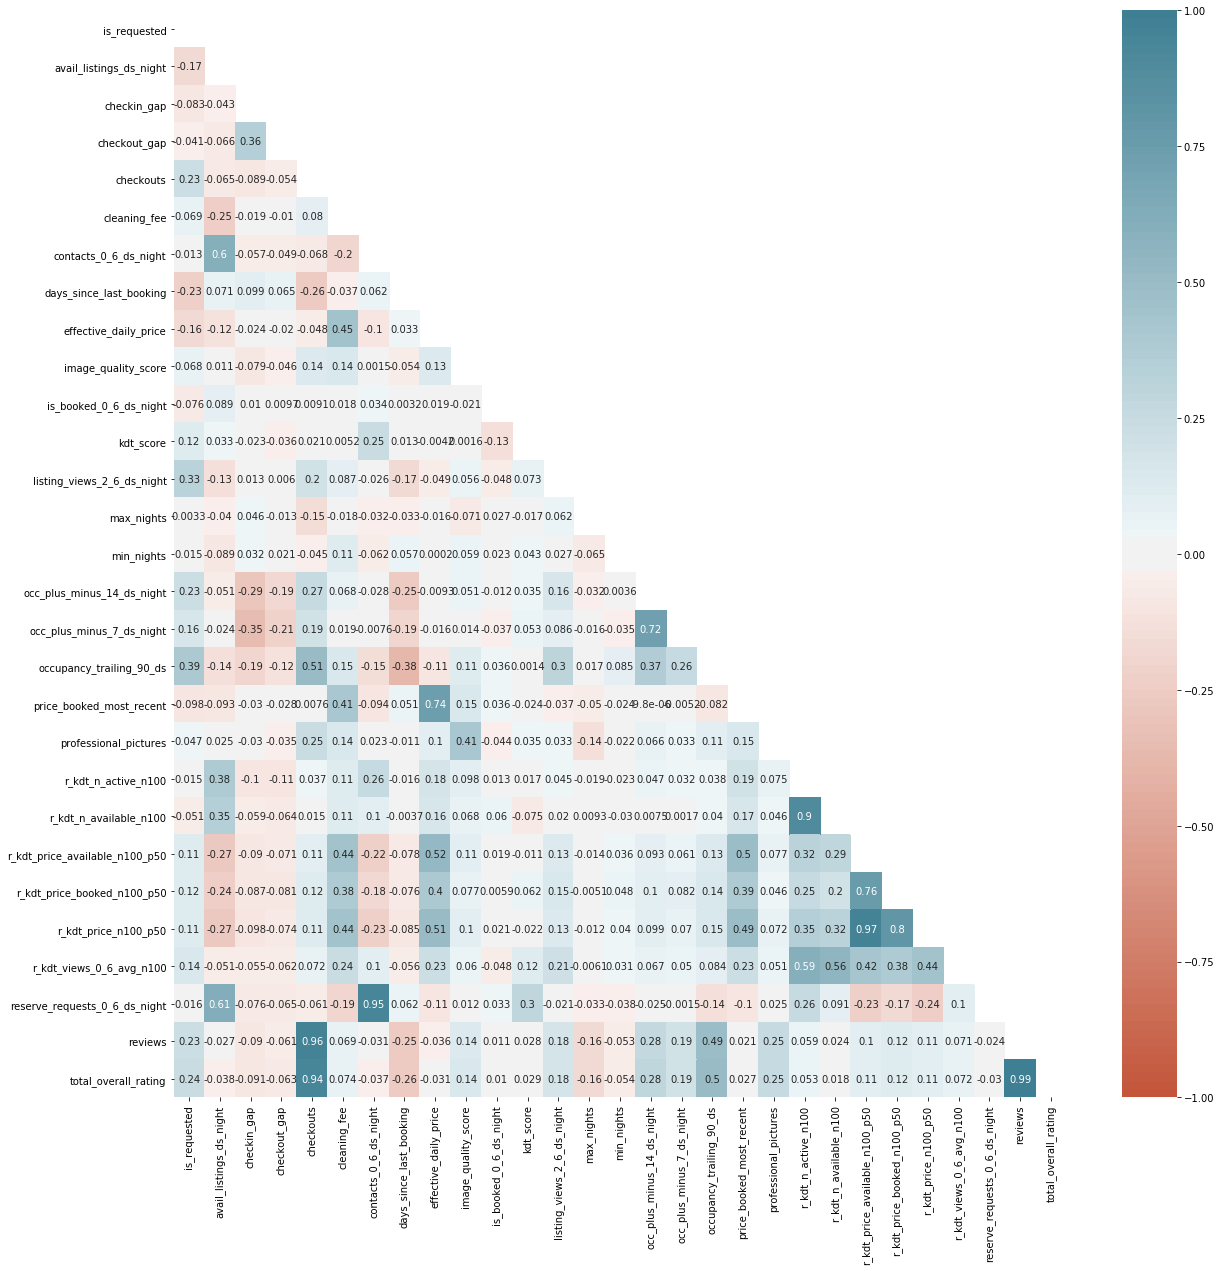

In [317]:
plt.figure(figsize=(20, 20))

# np.triu: https://numpy.org/doc/stable/reference/generated/numpy.triu.html
# sns.heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html
dat.corr().sort_values(by=['is_requested'], ascending=False).round(3)

matrix = np.triu(dat.corr())
sns.heatmap(dat.corr(), 
            annot=True, fmt='.2g', 
            mask=matrix, 
            vmin=-1, vmax=1, center=0, 
            cmap=sns.diverging_palette(20, 220, n=128));

<a id="pair_plots"></a>

# Visualize distributions of, and relationships between, target and predictors

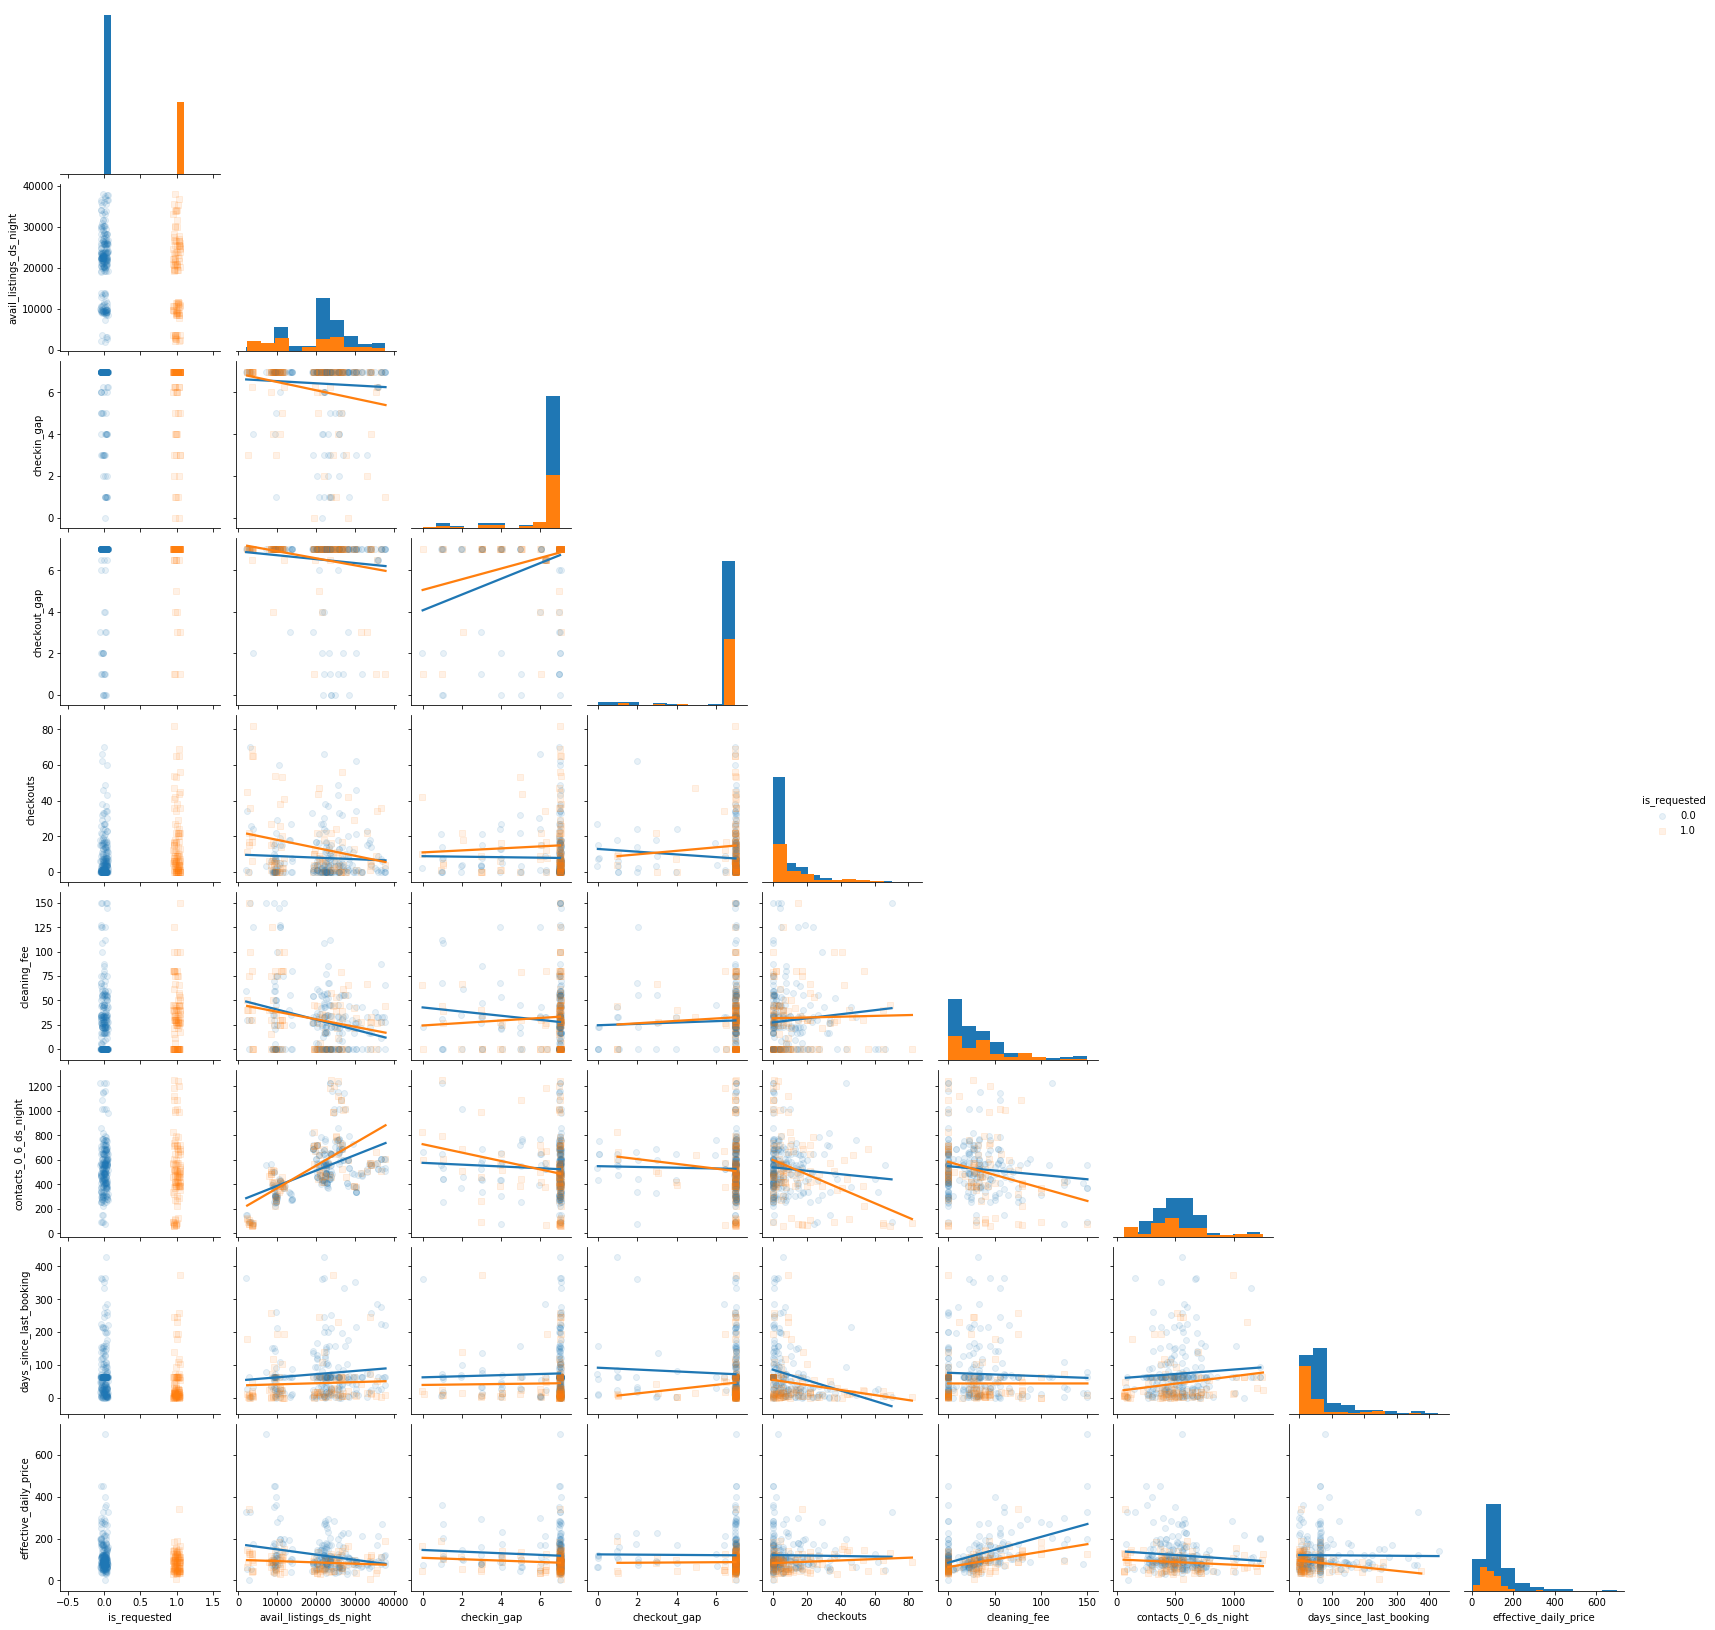

In [318]:
sns.pairplot(dat.sample(frac=.1, replace=False, random_state=42), 
             vars=list(dat.iloc[:,:9].columns), 
             kind='reg',
             diag_kind='hist',
             hue='is_requested', 
             markers=['o', 's'], 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.1}, 
                       'ci': None, 
                       'x_jitter': 0.05});

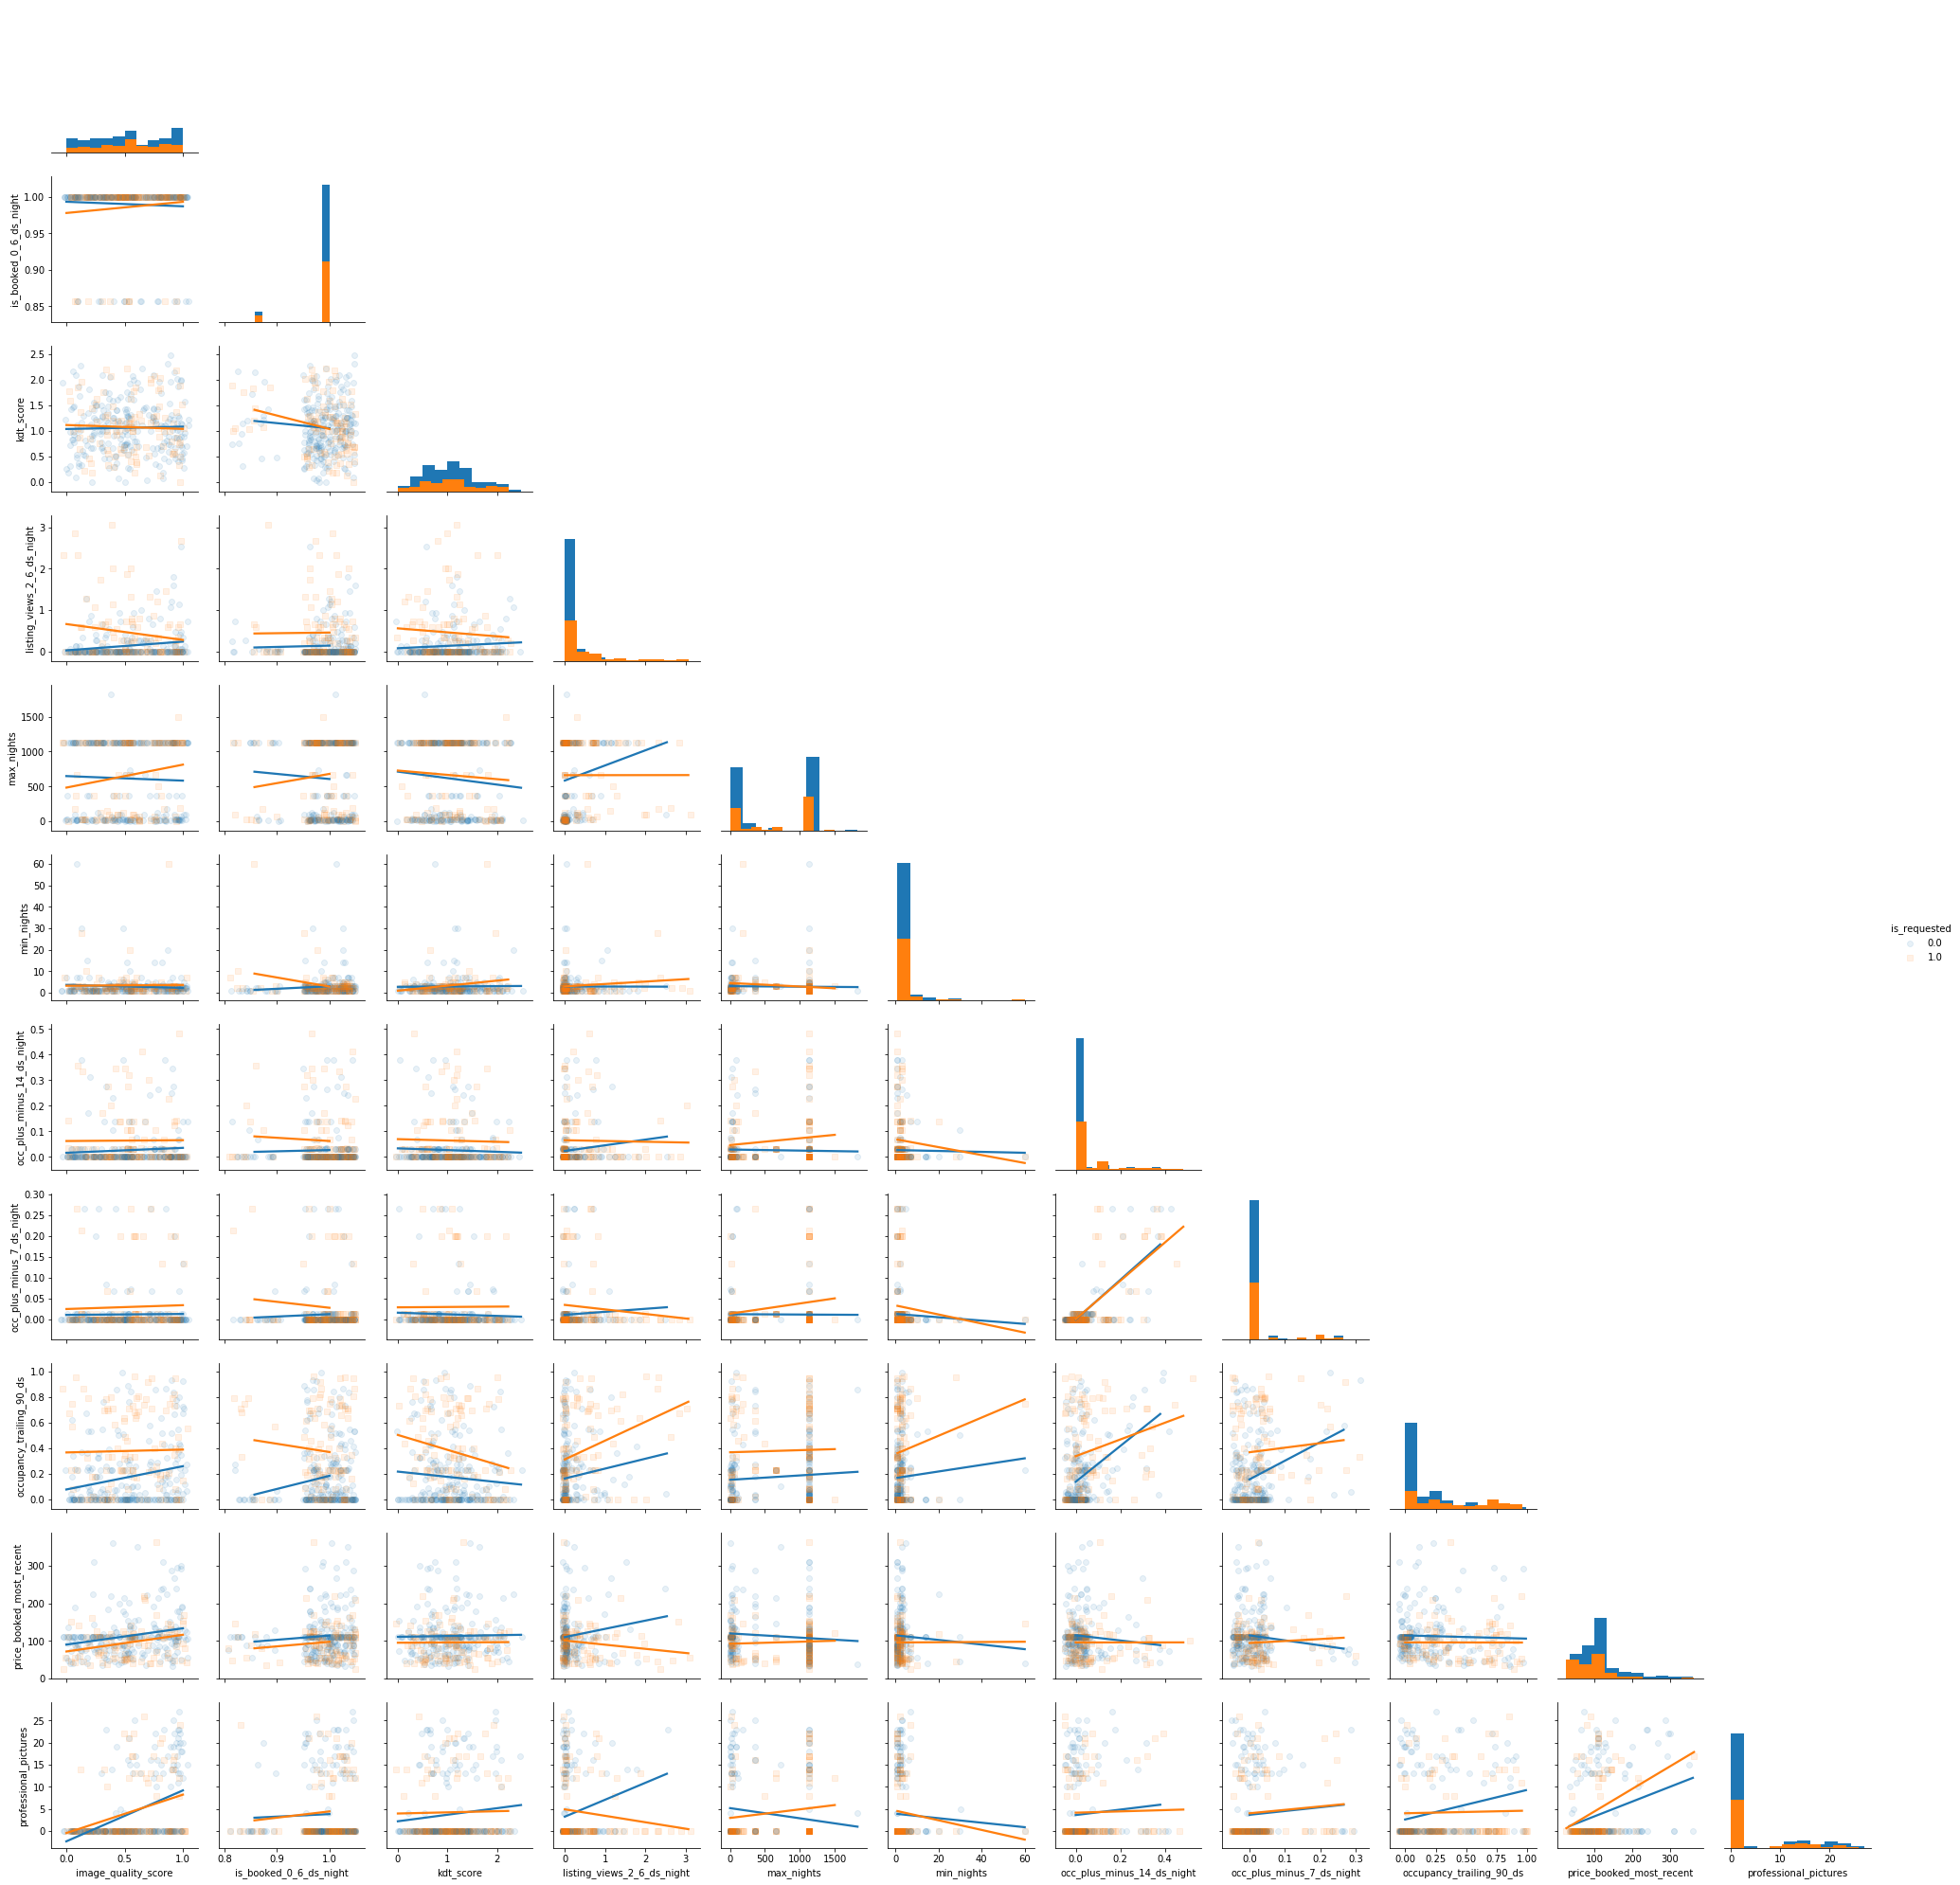

In [319]:
sns.pairplot(dat.sample(frac=.1, replace=False, random_state=42), 
             vars=list(dat.iloc[:,9:20].columns), 
             kind='reg',
             diag_kind='hist',
             hue='is_requested', 
             markers=['o', 's'], 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.1}, 
                       'ci': None, 
                       'x_jitter': 0.05});

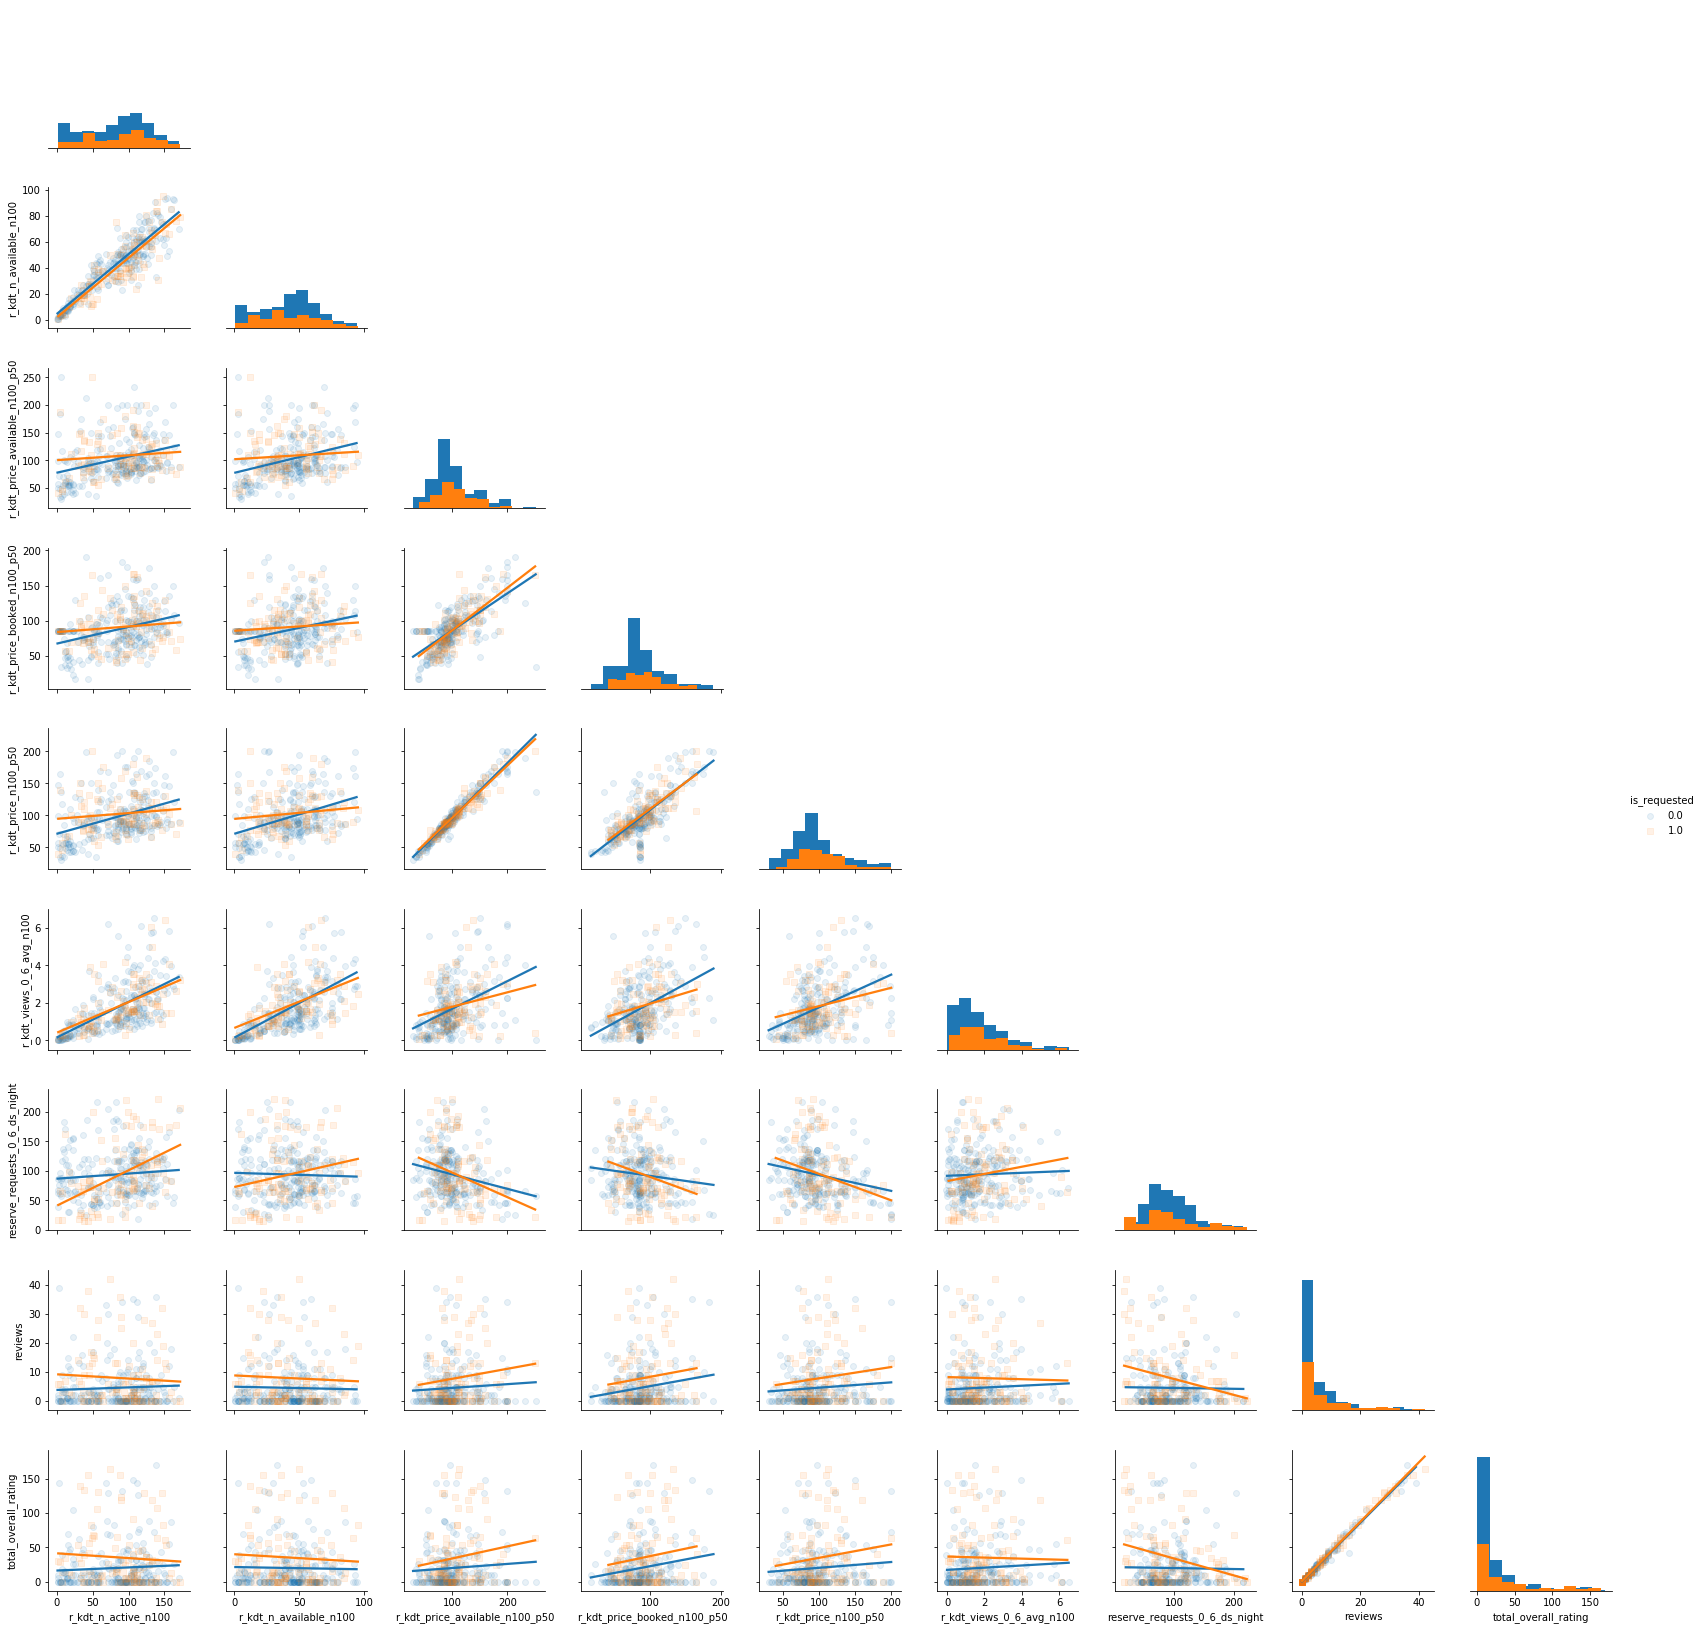

In [320]:
sns.pairplot(dat.sample(frac=.1, replace=False, random_state=42), 
             vars=list(dat.iloc[:,20:].columns), 
             kind='reg',
             diag_kind='hist',
             hue='is_requested', 
             markers=['o', 's'], 
             corner=True,  
             plot_kws={'scatter_kws': {'alpha': 0.1}, 
                       'ci': None, 
                       'x_jitter': 0.05});

<a id="standardize_predictors"></a>

# [Standardize](https://scikit-learn.org/stable/modules/preprocessing.html) the Predictors

In [321]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(data.iloc[:, 1:30].values)

X_train_tr = sc.transform(X_train[:,:29])
X_test_tr  = sc.transform( X_test[:,:29])

X_train_std = np.hstack((X_train_tr, X_train[:,29:]))
X_test_std  = np.hstack(( X_test_tr,  X_test[:,29:]))

In [322]:
X_train_std.shape, X_test_std.shape

((3311, 399), (1419, 399))

# View standardized predictor distributions by target category

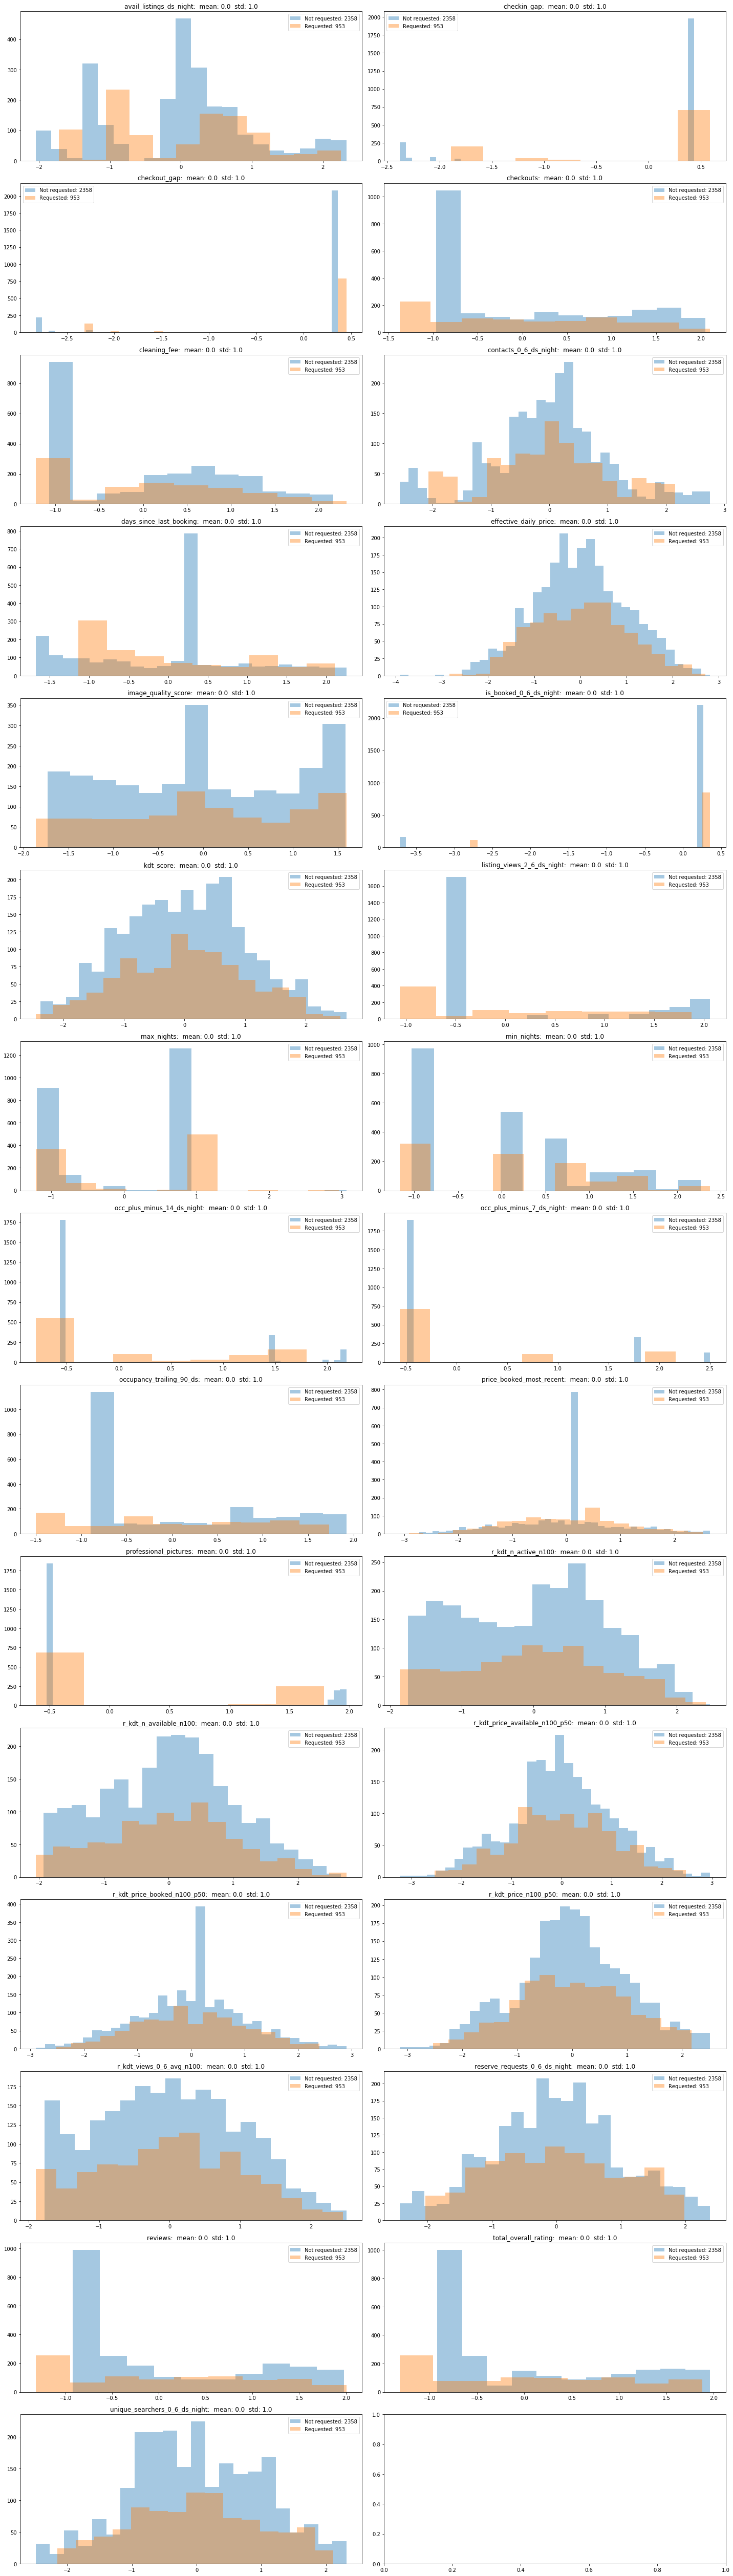

In [328]:
f, axs = plt.subplots(15, 2, figsize=(20,70))

pt = PowerTransformer(method='yeo-johnson')

for i, feat in enumerate(X_train_std[:,:29].T):
    sns.distplot(pt.fit_transform(feat[y_train==0].reshape(-1, 1)), ax=axs.flat[i], kde=False, label='{}: {}'.format('Not requested', len(y_train[y_train==0])))
    sns.distplot(pt.fit_transform(feat[y_train==1].reshape(-1, 1)), ax=axs.flat[i], kde=False, label='{}: {}'.format('Requested',     len(y_train[y_train==1])))
    axs.flat[i].set_title('{}:  mean: {}  std: {}'.format(list(data.iloc[:,1:30].columns)[i], abs(feat.mean().round(2)), feat.std().round(2)))
    axs.flat[i].legend()
plt.tight_layout();

<a id="predictive_models"></a>

# Predictive Models

# [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) estimator

In [329]:
from sklearn.dummy import DummyClassifier

d_clf = DummyClassifier(strategy='constant', constant=0)
d_clf.fit(X_train_std, y_train)

print('Accuracy (train): {:.2f}'.format(d_clf.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(d_clf.score(X_test_std,  y_test)))

Accuracy (train): 0.71
Accuracy  (test): 0.71


# [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

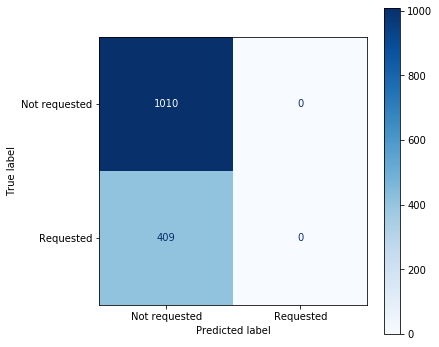

In [330]:
from sklearn.metrics import plot_confusion_matrix

class_labels = ['Not requested', 'Requested']

f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(d_clf, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # for float: '.2g'
                      normalize=None);

# [Classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [332]:
from sklearn.metrics import classification_report

y_pred = d_clf.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.71      1.00      0.83      1010
    Requested       0.00      0.00      0.00       409

     accuracy                           0.71      1419
    macro avg       0.36      0.50      0.42      1419
 weighted avg       0.51      0.71      0.59      1419



# [ROC curve](https://scikit-learn.org/stable/auto_examples/plot_roc_curve_visualization_api.html)

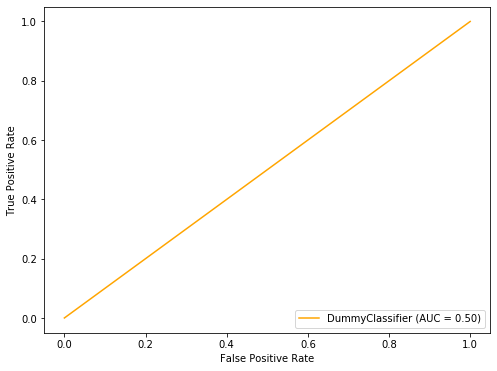

In [333]:
from sklearn.metrics import plot_roc_curve

f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(d_clf, X_test_std, y_test, ax=ax, color='orange');

<a id="logistic_regression"></a>

# [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [334]:
from sklearn.linear_model import LogisticRegressionCV

# Cs: Each of the values in Cs describes the inverse of regularization strength

# L1 Ratio: A value of 0 is equivalent to using penalty='l2'
#           A value of 1 is equivalent to using penalty='l1'
#           For 0 < l1_ratio <1, the penalty is a combination of L1 and L2
lr_clf = LogisticRegressionCV(cv=5, 
                              penalty='elasticnet', solver='saga', 
                              Cs=np.power(10, np.arange(-3, 1, dtype=float)), 
                              l1_ratios=np.linspace(0, 1, num=6, dtype=float), 
                              max_iter=1000, 
                              random_state=0)

start = time()
lr_clf.fit(X_train_std, y_train)
lr_duration = time() - start

print("LogisticRegressionCV took {:.2f} seconds for {} cv iterations with {} parameter settings.".format(lr_duration, 
                                                                                                         lr_clf.n_iter_.shape[1], 
                                                                                                         lr_clf.n_iter_.shape[2] * lr_clf.n_iter_.shape[3]))

print('Optimal regularization strength: {}  Optimal L1 Ratio: {}'.format(lr_clf.C_[0], lr_clf.l1_ratio_[0]))
print('Accuracy (train): {:.2f}'.format(lr_clf.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(lr_clf.score(X_test_std,  y_test)))

LogisticRegressionCV took 221.87 seconds for 5 cv iterations with 24 parameter settings.
Optimal regularization strength: 1.0  Optimal L1 Ratio: 0.2
Accuracy (train): 0.84
Accuracy  (test): 0.79


## [Model parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [335]:
lr_params = dict(zip(list(data.iloc[:, 1:].columns), list(lr_clf.coef_[0])), 
                 intercept=lr_clf.intercept_[0])
{param: value.round(2) for (param, value) in sorted(lr_params.items(), key=lambda item: item[1], reverse=True)}

{'day_of_year_229': 1.77,
 'day_of_year_213': 1.7,
 'day_of_year_151': 1.4,
 'total_overall_rating': 1.37,
 'day_of_year_275': 1.28,
 'day_of_year_83': 1.24,
 'day_of_year_148': 1.17,
 'day_of_year_243': 1.14,
 'day_of_year_163': 1.13,
 'person_capacity_7': 1.13,
 'day_of_year_167': 1.12,
 'day_of_year_181': 1.04,
 'day_of_year_234': 1.03,
 'day_of_year_257': 1.01,
 'day_of_year_53': 0.96,
 'day_of_year_68': 0.93,
 'day_of_year_188': 0.9,
 'day_of_year_43': 0.89,
 'day_of_year_344': 0.88,
 'day_of_year_353': 0.88,
 'day_of_year_67': 0.88,
 'day_of_year_56': 0.87,
 'day_of_year_45': 0.86,
 'day_of_year_311': 0.86,
 'has_wireless_internet': 0.86,
 'day_of_year_120': 0.82,
 'day_of_year_242': 0.8,
 'day_of_year_98': 0.79,
 'day_of_year_21': 0.79,
 'day_of_year_285': 0.78,
 'day_of_year_204': 0.72,
 'day_of_year_112': 0.72,
 'day_of_year_191': 0.71,
 'day_of_year_210': 0.7,
 'day_of_year_88': 0.7,
 'day_of_year_47': 0.7,
 'day_of_year_240': 0.69,
 'day_of_year_296': 0.69,
 'day_of_year_90'

## [Predicted class labels](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [336]:
predicted_class_labels = lr_clf.predict(X_test_std)
predicted_class_labels

array([0, 0, 1, ..., 1, 0, 0])

## [Predicted probabilities of class labels](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [337]:
predicted_class_probabilities = lr_clf.predict_proba(X_test_std)
[dict(zip(['Not requested(0)', 'Requested(1)'], map(lambda val: val.round(3), list(arr))), obs_id=i) 
 for (i, arr) in enumerate(list(predicted_class_probabilities))]

[{'Not requested(0)': 0.659, 'Requested(1)': 0.341, 'obs_id': 0},
 {'Not requested(0)': 0.975, 'Requested(1)': 0.025, 'obs_id': 1},
 {'Not requested(0)': 0.361, 'Requested(1)': 0.639, 'obs_id': 2},
 {'Not requested(0)': 0.516, 'Requested(1)': 0.484, 'obs_id': 3},
 {'Not requested(0)': 0.813, 'Requested(1)': 0.187, 'obs_id': 4},
 {'Not requested(0)': 0.82, 'Requested(1)': 0.18, 'obs_id': 5},
 {'Not requested(0)': 0.766, 'Requested(1)': 0.234, 'obs_id': 6},
 {'Not requested(0)': 0.864, 'Requested(1)': 0.136, 'obs_id': 7},
 {'Not requested(0)': 0.838, 'Requested(1)': 0.162, 'obs_id': 8},
 {'Not requested(0)': 0.911, 'Requested(1)': 0.089, 'obs_id': 9},
 {'Not requested(0)': 0.238, 'Requested(1)': 0.762, 'obs_id': 10},
 {'Not requested(0)': 0.388, 'Requested(1)': 0.612, 'obs_id': 11},
 {'Not requested(0)': 0.626, 'Requested(1)': 0.374, 'obs_id': 12},
 {'Not requested(0)': 0.994, 'Requested(1)': 0.006, 'obs_id': 13},
 {'Not requested(0)': 0.905, 'Requested(1)': 0.095, 'obs_id': 14},
 {'Not 

## [Cross-validation score](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) score on test set

In [338]:
from sklearn.model_selection import cross_val_score

def get_cross_val(clf, X, y, model_name, cv_num=5, metric='f1'):
    scores = cross_val_score(clf, X, y, cv=cv_num, scoring=metric)
    mean = scores.mean()
    std  = scores.std()
    p025 = np.quantile(scores, 0.025)
    p975 = np.quantile(scores, 0.975)
    metrics = ['mean', 'standard deviation', 'p025', 'p975']
    s = pd.Series([mean, std, p025, p975], index=metrics)  # np.where(lb < 0, 0, lb), np.where(ub > 1, 1, ub)
    s.name = model_name
    return s

In [339]:
lr_cv = get_cross_val(lr_clf, X_test_std, y_test, 'logistic regression')
lr_cv.round(2)

mean                  0.59
standard deviation    0.04
p025                  0.55
p975                  0.65
Name: logistic regression, dtype: float64

## [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

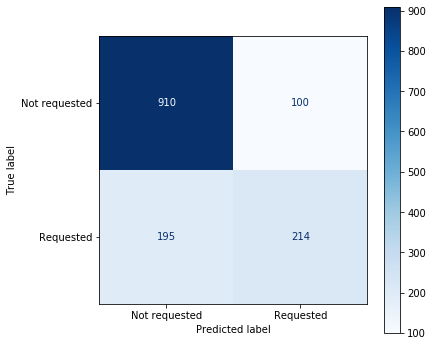

In [340]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(lr_clf, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## [Classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [341]:
y_pred = lr_clf.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.82      0.90      0.86      1010
    Requested       0.68      0.52      0.59       409

     accuracy                           0.79      1419
    macro avg       0.75      0.71      0.73      1419
 weighted avg       0.78      0.79      0.78      1419



## A collection of metrics for comparing models

In [342]:
def calculate_metrics(y_true, y_pred, duration, model_name, *args):
    acc     = accuracy_score(y_true, y_pred)
    pre     = precision_score(y_true, y_pred)
    rec     = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    f1      = f1_score(y_true, y_pred)
    ck      = cohen_kappa_score(y_true, y_pred)
    p, r, fbeta, support = precision_recall_fscore_support(y_true, y_pred)
    metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1_score', 'cohen_kappa',  
               'precision_both', 'recall_both', 'fbeta_both', 'support_both', 'time_to_fit (seconds)']
    s = pd.Series([acc, pre, rec, roc_auc, f1, ck, p, r, fbeta, support, duration], index=metrics)
    s.name = model_name
    return s

In [343]:
lr_metrics = calculate_metrics(y_test, y_pred, lr_duration, 'logistic_regression')
lr_metrics

accuracy                                                 0.792107
precision                                                0.681529
recall                                                   0.523227
roc_auc                                                  0.712109
f1_score                                                 0.591978
cohen_kappa                                               0.45571
precision_both           [0.8235294117647058, 0.6815286624203821]
recall_both               [0.900990099009901, 0.5232273838630807]
fbeta_both               [0.8605200945626477, 0.5919778699861687]
support_both                                          [1010, 409]
time_to_fit (seconds)                                      221.87
Name: logistic_regression, dtype: object

## [ROC curve](https://scikit-learn.org/stable/auto_examples/plot_roc_curve_visualization_api.html)

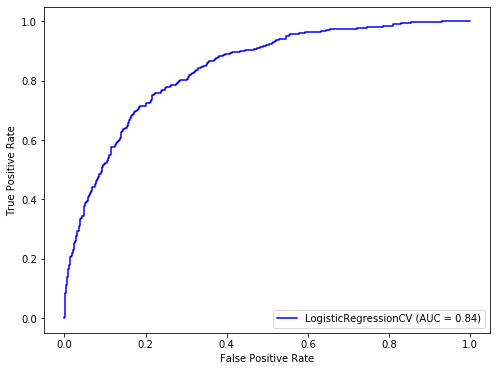

In [344]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(lr_clf, X_test_std, y_test, ax=ax, color='blue');

<a id="k_nearest_neighbors"></a>

# [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)

In [345]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': np.arange(1,16)}

knn_clf = KNeighborsClassifier()

gs_knn = GridSearchCV(knn_clf, param_grid=param_grid)

start = time()
gs_knn.fit(X_train_std, y_train)
knn_duration = time() - start

print("GridSearchCV of KNN took {:.2f} seconds for {} candidate parameter settings.".format(knn_duration, 
                                                                                            len(gs_knn.cv_results_['params'])))
# report(gs_knn.cv_results_)
print('Optimal weights: {}  Optimal n_neighbors: {}'.format(gs_knn.best_params_['weights'], gs_knn.best_params_['n_neighbors']))
print('Accuracy (train): {:.2f}'.format(gs_knn.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_knn.score(X_test_std,  y_test)))

GridSearchCV of KNN took 221.28 seconds for 30 candidate parameter settings.
Optimal weights: distance  Optimal n_neighbors: 7
Accuracy (train): 1.00
Accuracy  (test): 0.74


## Best parameters

In [346]:
pprint(gs_knn.best_estimator_.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'distance'}


## Cross-validation score on test set

In [347]:
knn_cv = get_cross_val(gs_knn, X_test_std, y_test, 'k-nearest neighbors')
knn_cv.round(2)

mean                  0.43
standard deviation    0.04
p025                  0.40
p975                  0.49
Name: k-nearest neighbors, dtype: float64

## Confusion matrix

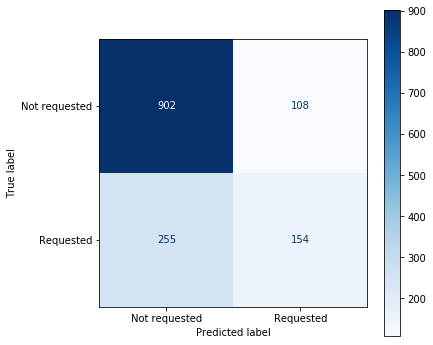

In [348]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_knn, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [349]:
y_pred = gs_knn.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.78      0.89      0.83      1010
    Requested       0.59      0.38      0.46       409

     accuracy                           0.74      1419
    macro avg       0.68      0.63      0.65      1419
 weighted avg       0.72      0.74      0.72      1419



## A collection of metrics for comparing models

In [350]:
knn_metrics = calculate_metrics(y_test, y_pred, knn_duration, 'k-nearest neighbors')
knn_metrics

accuracy                                                 0.744186
precision                                                0.587786
recall                                                   0.376528
roc_auc                                                  0.634799
f1_score                                                 0.459016
cohen_kappa                                              0.301879
precision_both           [0.7796024200518582, 0.5877862595419847]
recall_both              [0.8930693069306931, 0.3765281173594132]
fbeta_both                 [0.83248730964467, 0.4590163934426229]
support_both                                          [1010, 409]
time_to_fit (seconds)                                     221.279
Name: k-nearest neighbors, dtype: object

## ROC curve

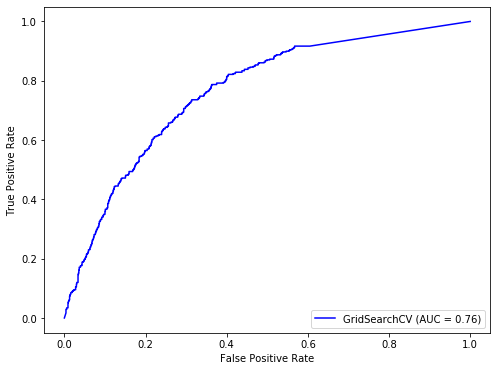

In [351]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_knn, X_test_std, y_test, ax=ax, color='blue');

<a id="linear_discriminant_analysis"></a>

# [Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/lda_qda.html)

In [352]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver': ['lsqr', 'eigen'],
              'shrinkage': [None, 'auto'], 
              'n_components': np.arange(1,5)}

lda_clf = LinearDiscriminantAnalysis()

gs_lda = GridSearchCV(lda_clf, param_grid=param_grid)

start = time()
gs_lda.fit(X_train_std, y_train)
lda_duration = time() - start

print("GridSearchCV of LDA took {:.2f} seconds for {} candidate parameter settings.".format(lda_duration, 
                                                                                            len(gs_lda.cv_results_['params'])))
# report(gs_lda.cv_results_)
print('Optimal solver: {}  Optimal shrinkage: {}  Optimal n_components: {}'.format(gs_lda.best_params_['solver'], gs_lda.best_params_['shrinkage'], gs_lda.best_params_['n_components']))
print('Accuracy (train): {:.2f}'.format(gs_lda.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_lda.score(X_test_std,  y_test)))

GridSearchCV of LDA took 12.45 seconds for 16 candidate parameter settings.
Optimal solver: lsqr  Optimal shrinkage: None  Optimal n_components: 1
Accuracy (train): 0.84
Accuracy  (test): 0.76


## Cross-validation score on test set

In [353]:
lda_cv = get_cross_val(lda_clf, X_test_std, y_test, 'linear discriminanat analysis')
lda_cv.round(2)

mean                  0.53
standard deviation    0.03
p025                  0.47
p975                  0.55
Name: linear discriminanat analysis, dtype: float64

## Confusion matrix

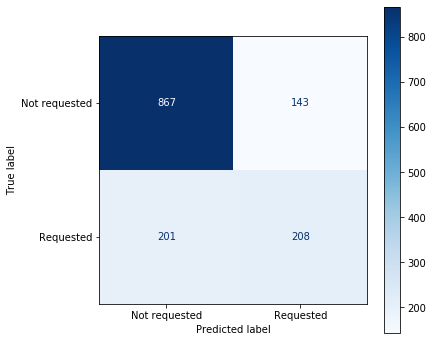

In [354]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_lda, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [355]:
y_pred = gs_lda.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.81      0.86      0.83      1010
    Requested       0.59      0.51      0.55       409

     accuracy                           0.76      1419
    macro avg       0.70      0.68      0.69      1419
 weighted avg       0.75      0.76      0.75      1419



## A collection of metrics for comparing models

In [356]:
lda_metrics = calculate_metrics(y_test, y_pred, lda_duration, 'linear discriminant analysis')
lda_metrics

accuracy                                                 0.757576
precision                                                0.592593
recall                                                   0.508557
roc_auc                                                  0.683487
f1_score                                                 0.547368
cohen_kappa                                              0.383139
precision_both           [0.8117977528089888, 0.5925925925925926]
recall_both               [0.8584158415841584, 0.508557457212714]
fbeta_both               [0.8344562078922041, 0.5473684210526315]
support_both                                          [1010, 409]
time_to_fit (seconds)                                     12.4494
Name: linear discriminant analysis, dtype: object

## ROC curve

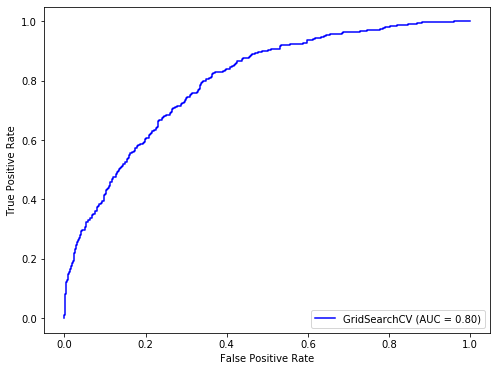

In [357]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_lda, X_test_std, y_test, ax=ax, color='blue');

<a id="support_vector_machines"></a>

# [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#classification)

In [358]:
from sklearn.svm import SVC

param_grid = {'C': np.power(10, np.arange(0, 3, dtype=float)),
              'kernel': ['linear', 'sigmoid', 'rbf'], 
              'gamma': ['auto', 'scale']}

svc_clf = SVC(random_state=0)

gs_svc = GridSearchCV(svc_clf, param_grid=param_grid)

start = time()
gs_svc.fit(X_train_std, y_train)
svc_duration = time() - start

print("GridSearchCV of SVC took {:.2f} seconds for {} candidate parameter settings.".format(svc_duration, 
                                                                                            len(gs_svc.cv_results_['params'])))
# report(gs_svc.cv_results_)
print('Optimal C: {}  Optimal kernel: {}  Optimal gamma: {}'.format(gs_svc.best_params_['C'], gs_svc.best_params_['kernel'], gs_svc.best_params_['gamma']))
print('Accuracy (train): {:.2f}'.format(gs_svc.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_svc.score(X_test_std,  y_test)))

GridSearchCV of SVC took 1042.26 seconds for 18 candidate parameter settings.
Optimal C: 100.0  Optimal kernel: sigmoid  Optimal gamma: auto
Accuracy (train): 0.82
Accuracy  (test): 0.79


## Cross-validation score on test set

In [359]:
svc_cv = get_cross_val(gs_svc, X_test_std, y_test, 'support vector machines')
svc_cv.round(2)

mean                  0.56
standard deviation    0.02
p025                  0.52
p975                  0.58
Name: support vector machines, dtype: float64

## Confusion matrix

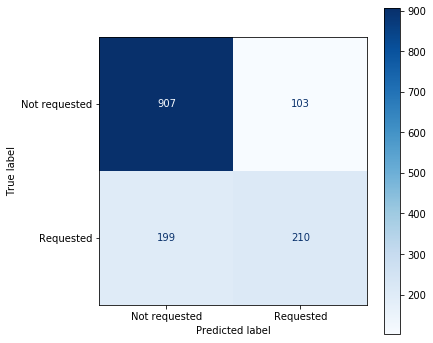

In [360]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_svc, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [361]:
y_pred = gs_svc.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.82      0.90      0.86      1010
    Requested       0.67      0.51      0.58       409

     accuracy                           0.79      1419
    macro avg       0.75      0.71      0.72      1419
 weighted avg       0.78      0.79      0.78      1419



## A collection of metrics for comparing models

In [362]:
svc_metrics = calculate_metrics(y_test, y_pred, svc_duration, 'support vector machines')
svc_metrics

accuracy                                                 0.787174
precision                                                0.670927
recall                                                   0.513447
roc_auc                                                  0.705734
f1_score                                                 0.581717
cohen_kappa                                              0.442359
precision_both            [0.8200723327305606, 0.670926517571885]
recall_both               [0.898019801980198, 0.5134474327628362]
fbeta_both               [0.8572778827977316, 0.5817174515235457]
support_both                                          [1010, 409]
time_to_fit (seconds)                                     1042.26
Name: support vector machines, dtype: object

## ROC curve

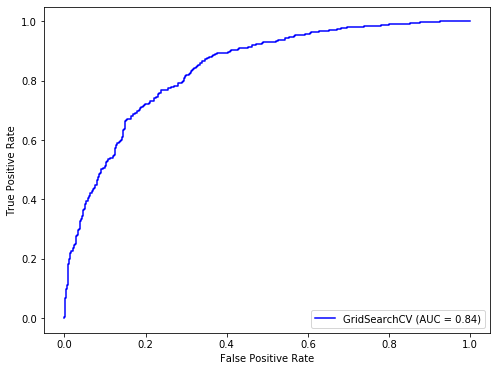

In [363]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_svc, X_test_std, y_test, ax=ax, color='blue');

<a id="extra_trees"></a>

# [Extremely Randomized Trees](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)

In [365]:
from sklearn.ensemble import ExtraTreesClassifier

param_grid = {'n_estimators': np.arange(100, 1000, 200, dtype=int),
              'max_features': [None, 'sqrt', 'log2'],
              'criterion': ['gini', 'entropy'],
              'max_depth': [None, 3, 5, 7]}

et_clf = ExtraTreesClassifier(random_state=0, n_jobs=3)

gs_et = GridSearchCV(et_clf, param_grid=param_grid)

start = time()
gs_et.fit(X_train_std, y_train)
et_duration = time() - start

print("GridSearchCV of ET took {:.2f} seconds for {} candidate parameter settings.".format(et_duration, 
                                                                                           len(gs_et.cv_results_['params'])))
# report(gs_et.cv_results_)
print('Optimal n_estimators: {}  Optimal max_features: {}  Optimal max_depth: {}  Optimal criterion: {}'.format(gs_et.best_params_['n_estimators'], 
                                                                                                                gs_et.best_params_['max_features'], 
                                                                                                                gs_et.best_params_['max_depth'], 
                                                                                                                gs_et.best_params_['criterion']))
print('Accuracy (train): {:.2f}'.format(gs_et.score(X_train_std, y_train)))
print('Accuracy  (test): {:.2f}'.format(gs_et.score(X_test_std,  y_test)))

GridSearchCV of ET took 1913.10 seconds for 120 candidate parameter settings.
Optimal n_estimators: 900  Optimal max_features: None  Optimal max_depth: None  Optimal criterion: entropy
Accuracy (train): 1.00
Accuracy  (test): 0.79


## Cross-validation score on test set

In [380]:
clf_et = ExtraTreesClassifier(n_estimators=gs_et.best_params_['n_estimators'], 
                              max_features=gs_et.best_params_['max_features'], 
                              max_depth=gs_et.best_params_['max_depth'], 
                              criterion=gs_et.best_params_['criterion'], 
                              random_state=0, 
                              n_jobs=3)

et_cv = get_cross_val(clf_et, X_test_std, y_test, 'extra trees')
et_cv.round(2)

mean                  0.51
standard deviation    0.06
p025                  0.41
p975                  0.58
Name: extra trees, dtype: float64

## Confusion matrix

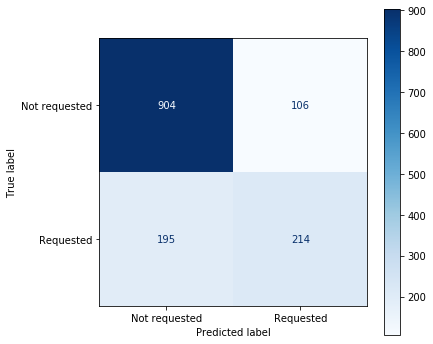

In [367]:
f, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(gs_et, X_test_std, y_test, 
                      ax=ax,
                      display_labels=class_labels, 
                      cmap=plt.cm.Blues, 
                      values_format='d', # '.2g'
                      normalize=None);

## Classification report

In [368]:
y_pred = gs_et.predict(X_test_std)

print(classification_report(y_test, y_pred, 
                            target_names=class_labels))

               precision    recall  f1-score   support

Not requested       0.82      0.90      0.86      1010
    Requested       0.67      0.52      0.59       409

     accuracy                           0.79      1419
    macro avg       0.75      0.71      0.72      1419
 weighted avg       0.78      0.79      0.78      1419



## A collection of metrics for comparing models

In [381]:
et_metrics = calculate_metrics(y_test, y_pred, et_duration, 'extra trees')
et_metrics

accuracy                                                 0.787879
precision                                                 0.66875
recall                                                   0.523227
roc_auc                                                  0.709138
f1_score                                                 0.587106
cohen_kappa                                              0.447232
precision_both                      [0.8225659690627843, 0.66875]
recall_both              [0.8950495049504951, 0.5232273838630807]
fbeta_both               [0.8572783309625415, 0.5871056241426612]
support_both                                          [1010, 409]
time_to_fit (seconds)                                      1913.1
Name: extra trees, dtype: object

## ROC curve

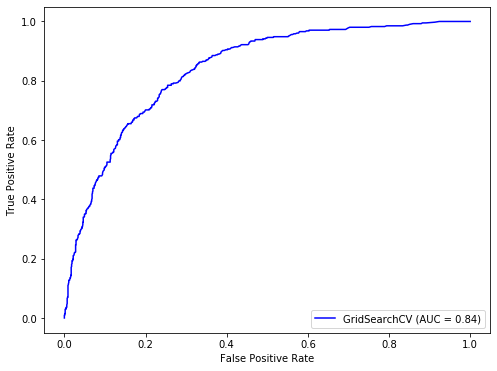

In [370]:
f, ax = plt.subplots(figsize=(8,6))
plot_roc_curve(gs_et, X_test_std, y_test, ax=ax, color='blue');

## [Variable importances](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) in the extra trees model

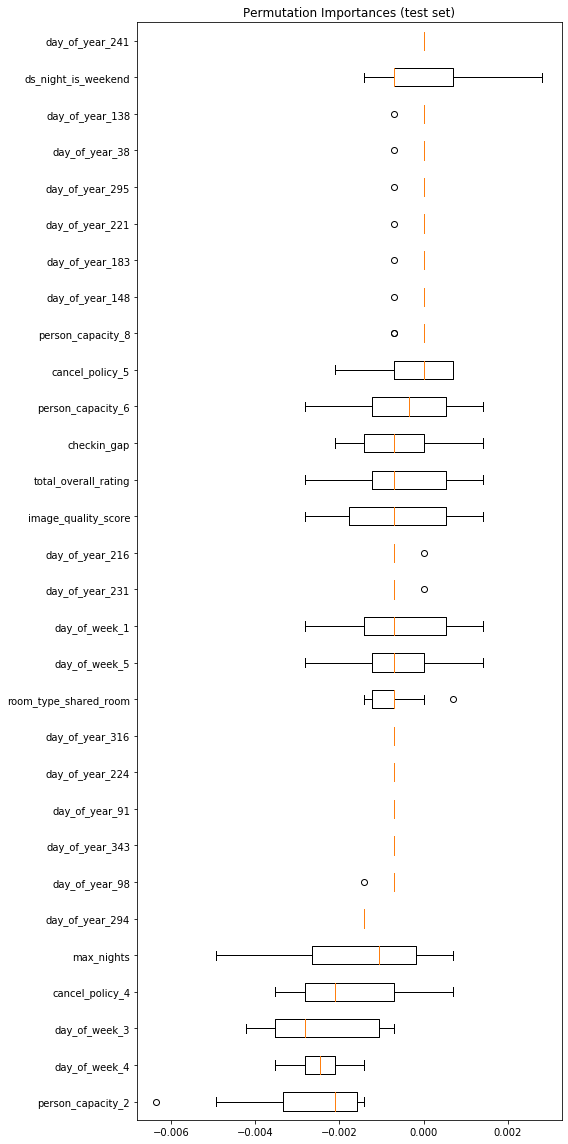

In [375]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gs_et, X_test_std, y_test, n_repeats=10, 
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[:30] # top 30

X_test_df = pd.DataFrame(X_test_std, columns=list(data.iloc[:, 1:].columns))

f, ax = plt.subplots(figsize=(8,16))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_df.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.tight_layout();

<a id="compare_models"></a>

# Compare Models

## Classification metrics scores and time-to-fit models (in seconds)

In [382]:
model_metrics = pd.concat([lr_metrics, knn_metrics, lda_metrics, svc_metrics, et_metrics], axis=1).T

model_metrics.apply(lambda elem: [np.round(val, 2) for val in elem]).sort_values(by='f1_score', ascending=False)

,accuracy,precision,recall,roc_auc,f1_score,cohen_kappa,precision_both,recall_both,fbeta_both,support_both,time_to_fit (seconds)
logistic_regression,0.79,0.68,0.52,0.71,0.59,0.46,"[0.82, 0.68]","[0.9, 0.52]","[0.86, 0.59]","[1010, 409]",221.87
extra trees,0.79,0.67,0.52,0.71,0.59,0.45,"[0.82, 0.67]","[0.9, 0.52]","[0.86, 0.59]","[1010, 409]",1913.10
support vector machines,0.79,0.67,0.51,0.71,0.58,0.44,"[0.82, 0.67]","[0.9, 0.51]","[0.86, 0.58]","[1010, 409]",1042.26
linear discriminant analysis,0.76,0.59,0.51,0.68,0.55,0.38,"[0.81, 0.59]","[0.86, 0.51]","[0.83, 0.55]","[1010, 409]",12.45
k-nearest neighbors,0.74,0.59,0.38,0.63,0.46,0.30,"[0.78, 0.59]","[0.89, 0.38]","[0.83, 0.46]","[1010, 409]",221.28


## Cross-validation scores on test set

In [383]:
cross_vals = pd.concat([lr_cv, knn_cv, lda_cv, svc_cv, et_cv], axis=1).T

cross_vals = cross_vals.round(2).sort_values(by='mean', ascending=False)
cross_vals

,mean,standard deviation,p025,p975
logistic regression,0.59,0.04,0.55,0.65
support vector machines,0.56,0.02,0.52,0.58
linear discriminanat analysis,0.53,0.03,0.47,0.55
extra trees,0.51,0.06,0.41,0.58
k-nearest neighbors,0.43,0.04,0.40,0.49


## Plot of mean (+/- std) cross-validation scores

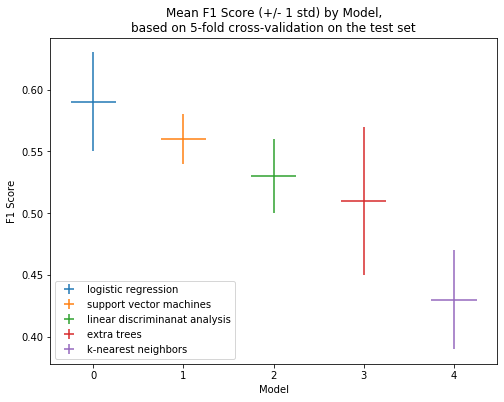

In [384]:
fig = plt.figure(figsize=(8,6))

for i in range(len(cross_vals.index)):
    plt.errorbar(x=i, y=cross_vals.iloc[i, 0], # mean column
                 xerr=0.25,
                 yerr=cross_vals.iloc[i, 1], # standard deviation column   alternatively: [mean - p025, p975 - mean],
                 linestyle='',
                 label=list(cross_vals.index)[i])

#plt.ylim(0.7,1)
plt.title('Mean F1 Score (+/- 1 std) by Model,\nbased on 5-fold cross-validation on the test set')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.legend(loc='lower left');

[Back to top](#top)